#### Libraries

In [212]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

import xgboost as xgb

import warnings

#### Variables

In [172]:
data_filepath = 'data/DisasterDeclarationsSummaries.csv'

#### Suppress Warnings

In [173]:
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Read Data

In [174]:
df = pd.read_csv(data_filepath)

#### Select Columns for Model

In [175]:
df = df[['id', 'state', 'declarationType', 'declarationDate', 'incidentType', 'ihProgramDeclared', 'iaProgramDeclared',
         'paProgramDeclared', 'hmProgramDeclared', 'incidentBeginDate', 'incidentEndDate', 'tribalRequest']]
df.head()

,id,state,declarationType,declarationDate,incidentType,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,tribalRequest
0,e46df225-24a5-4178-9368-0f1c753f8748,NM,FM,2023-05-10T00:00:00.000Z,Fire,0,0,1,1,2023-05-10T00:00:00.000Z,NaN,0
1,c8660535-8995-4187-af20-771b5669d4b7,NM,FM,2023-05-10T00:00:00.000Z,Fire,0,0,1,1,2023-05-10T00:00:00.000Z,NaN,0
2,9b9a9d9c-8b03-4049-9b16-a3c0d581556c,RI,FM,2023-04-14T00:00:00.000Z,Fire,0,0,1,1,2023-04-14T00:00:00.000Z,2023-04-16T00:00:00.000Z,0
3,57d936ce-a0d7-412a-9d78-18aee530c146,KS,FM,2023-04-13T00:00:00.000Z,Fire,0,0,1,1,2023-04-13T00:00:00.000Z,2023-04-16T00:00:00.000Z,0
4,69325b2c-77cf-493f-8f1a-d5b5a737edf8,NE,FM,2023-04-09T00:00:00.000Z,Fire,0,0,1,1,2023-04-08T00:00:00.000Z,NaN,0


#### Convert columns with values 1 and 0 to true or false

In [176]:
columns_to_convert = ['ihProgramDeclared', 'iaProgramDeclared', 'paProgramDeclared', 'hmProgramDeclared', 'tribalRequest']

for column in columns_to_convert:
    df[column] = df[column].astype(bool)
df.head()

,id,state,declarationType,declarationDate,incidentType,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,tribalRequest
0,e46df225-24a5-4178-9368-0f1c753f8748,NM,FM,2023-05-10T00:00:00.000Z,Fire,False,False,True,True,2023-05-10T00:00:00.000Z,NaN,False
1,c8660535-8995-4187-af20-771b5669d4b7,NM,FM,2023-05-10T00:00:00.000Z,Fire,False,False,True,True,2023-05-10T00:00:00.000Z,NaN,False
2,9b9a9d9c-8b03-4049-9b16-a3c0d581556c,RI,FM,2023-04-14T00:00:00.000Z,Fire,False,False,True,True,2023-04-14T00:00:00.000Z,2023-04-16T00:00:00.000Z,False
3,57d936ce-a0d7-412a-9d78-18aee530c146,KS,FM,2023-04-13T00:00:00.000Z,Fire,False,False,True,True,2023-04-13T00:00:00.000Z,2023-04-16T00:00:00.000Z,False
4,69325b2c-77cf-493f-8f1a-d5b5a737edf8,NE,FM,2023-04-09T00:00:00.000Z,Fire,False,False,True,True,2023-04-08T00:00:00.000Z,NaN,False


#### Save disasters with no end date for the end, so we can make a prediction as to when it will end

In [177]:
df_no_end_date = df[df['incidentEndDate'].isna()]
df_no_end_date.info()

<class 'pandas.core.frame.DataFrame'>
Index: 534 entries, 0 to 64691
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 534 non-null    object
 1   state              534 non-null    object
 2   declarationType    534 non-null    object
 3   declarationDate    534 non-null    object
 4   incidentType       534 non-null    object
 5   ihProgramDeclared  534 non-null    bool  
 6   iaProgramDeclared  534 non-null    bool  
 7   paProgramDeclared  534 non-null    bool  
 8   hmProgramDeclared  534 non-null    bool  
 9   incidentBeginDate  534 non-null    object
 10  incidentEndDate    0 non-null      object
 11  tribalRequest      534 non-null    bool  
dtypes: bool(5), object(7)
memory usage: 36.0+ KB


In [178]:
df = df[~df['incidentEndDate'].isna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64351 entries, 2 to 64884
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 64351 non-null  object
 1   state              64351 non-null  object
 2   declarationType    64351 non-null  object
 3   declarationDate    64351 non-null  object
 4   incidentType       64351 non-null  object
 5   ihProgramDeclared  64351 non-null  bool  
 6   iaProgramDeclared  64351 non-null  bool  
 7   paProgramDeclared  64351 non-null  bool  
 8   hmProgramDeclared  64351 non-null  bool  
 9   incidentBeginDate  64351 non-null  object
 10  incidentEndDate    64351 non-null  object
 11  tribalRequest      64351 non-null  bool  
dtypes: bool(5), object(7)
memory usage: 4.2+ MB


#### Calculate Incident Duration, and declaration month

In [179]:
# Calculate incident duration for each disaster
df.loc[:, 'incidentDuration'] = (pd.to_datetime(df['incidentEndDate']) - pd.to_datetime(df['incidentBeginDate'])).dt.days
df.loc[:, 'declarationMonth'] = pd.to_datetime(df['declarationDate']).dt.month
df = df.drop(columns=['incidentBeginDate', 'incidentEndDate', 'declarationDate'])
df = df.reset_index(drop=True)
df.head()

,id,state,declarationType,incidentType,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,tribalRequest,incidentDuration,declarationMonth
0,9b9a9d9c-8b03-4049-9b16-a3c0d581556c,RI,FM,Fire,False,False,True,True,False,2,4
1,57d936ce-a0d7-412a-9d78-18aee530c146,KS,FM,Fire,False,False,True,True,False,3,4
2,57cd8ff3-7ea3-49f6-923c-0c2573fa6582,TX,FM,Fire,False,False,True,True,False,19,7
3,689b511c-20a5-4037-b326-9c7046bbb0bc,TX,FM,Fire,False,False,True,True,False,19,7
4,9d62e711-dfe1-463d-a793-088912626de9,TX,FM,Fire,False,False,True,True,False,9,7


#### Get summary statistics for target variable, incidentDuration

In [180]:
df['incidentDuration'].describe()

count    64351.000000
mean       167.369054
std        389.556621
min         -7.000000
25%          3.000000
50%         13.000000
75%         42.000000
max       5117.000000
Name: incidentDuration, dtype: float64

#### Average Incident Duration per State
Annotated numbers represent the number of incidences per state

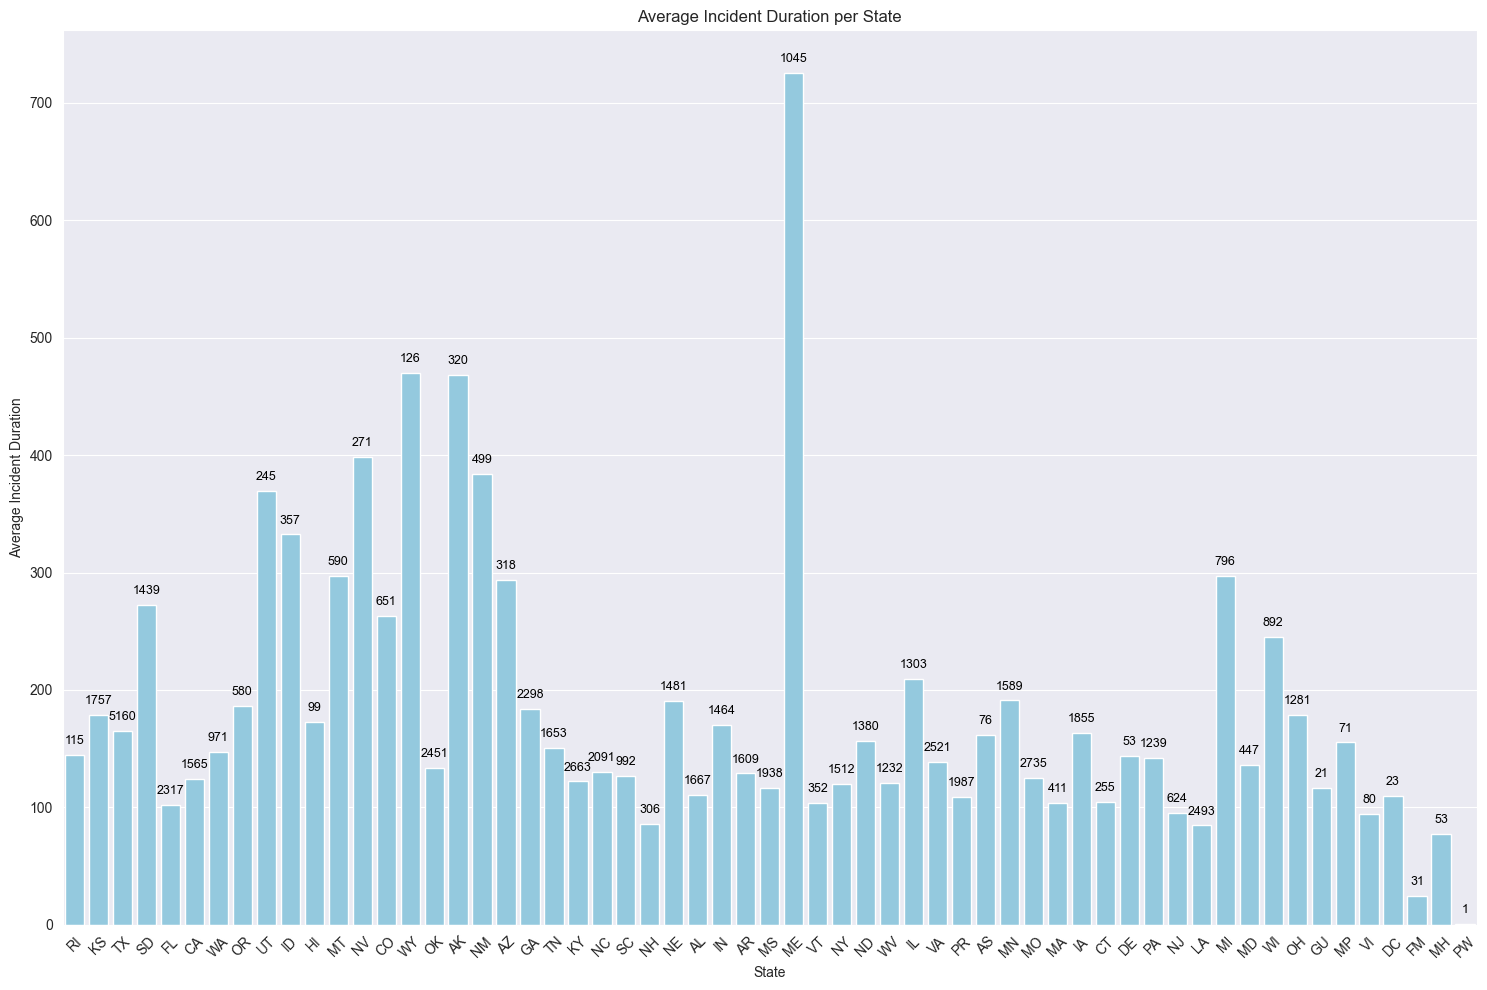

In [181]:
# Calculate the number of incidents for each state
incident_counts = df.groupby('state').size().reset_index(name='counts')

plt.figure(figsize=(15, 10))
barplot = sns.barplot(x='state', y='incidentDuration', data=df, estimator=np.mean, ci=None, color='skyblue')
plt.title('Average Incident Duration per State')
plt.xlabel('State')
plt.ylabel('Average Incident Duration')
plt.xticks(rotation=45)

# Annotate bars with the number of incidents
for idx, p in enumerate(barplot.patches):
    count = incident_counts.loc[incident_counts['state'] == barplot.get_xticklabels()[idx].get_text(), 'counts'].iloc[0]
    barplot.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=9, color='black', xytext=(0, 10),
                     textcoords='offset points')

plt.tight_layout()
plt.show()

#### Average Incident Duration by Delclaration Type
Annotated numbers represent the number of incidences per declaration type

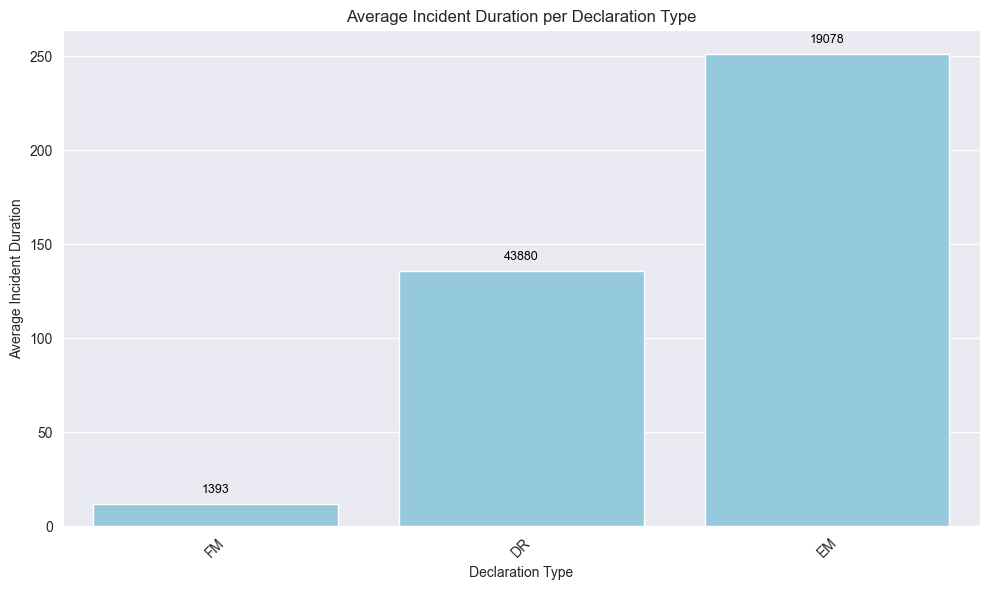

In [182]:
# Calculate the number of incidents for each declarationType
incident_counts = df.groupby('declarationType').size().reset_index(name='counts')

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='declarationType', y='incidentDuration', data=df, estimator=np.mean, ci=None, color='skyblue')
plt.title('Average Incident Duration per Declaration Type')
plt.xlabel('Declaration Type')
plt.ylabel('Average Incident Duration')
plt.xticks(rotation=45)

# Annotate bars with the number of incidents
for idx, p in enumerate(barplot.patches):
    count = incident_counts.loc[incident_counts['declarationType'] == barplot.get_xticklabels()[idx].get_text(), 'counts'].iloc[0]
    barplot.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=9, color='black', xytext=(0, 10),
                     textcoords='offset points')

plt.tight_layout()
plt.show()

#### Average Incident Duration by incident type
Annotated numbers represent the number of incidences per incident type

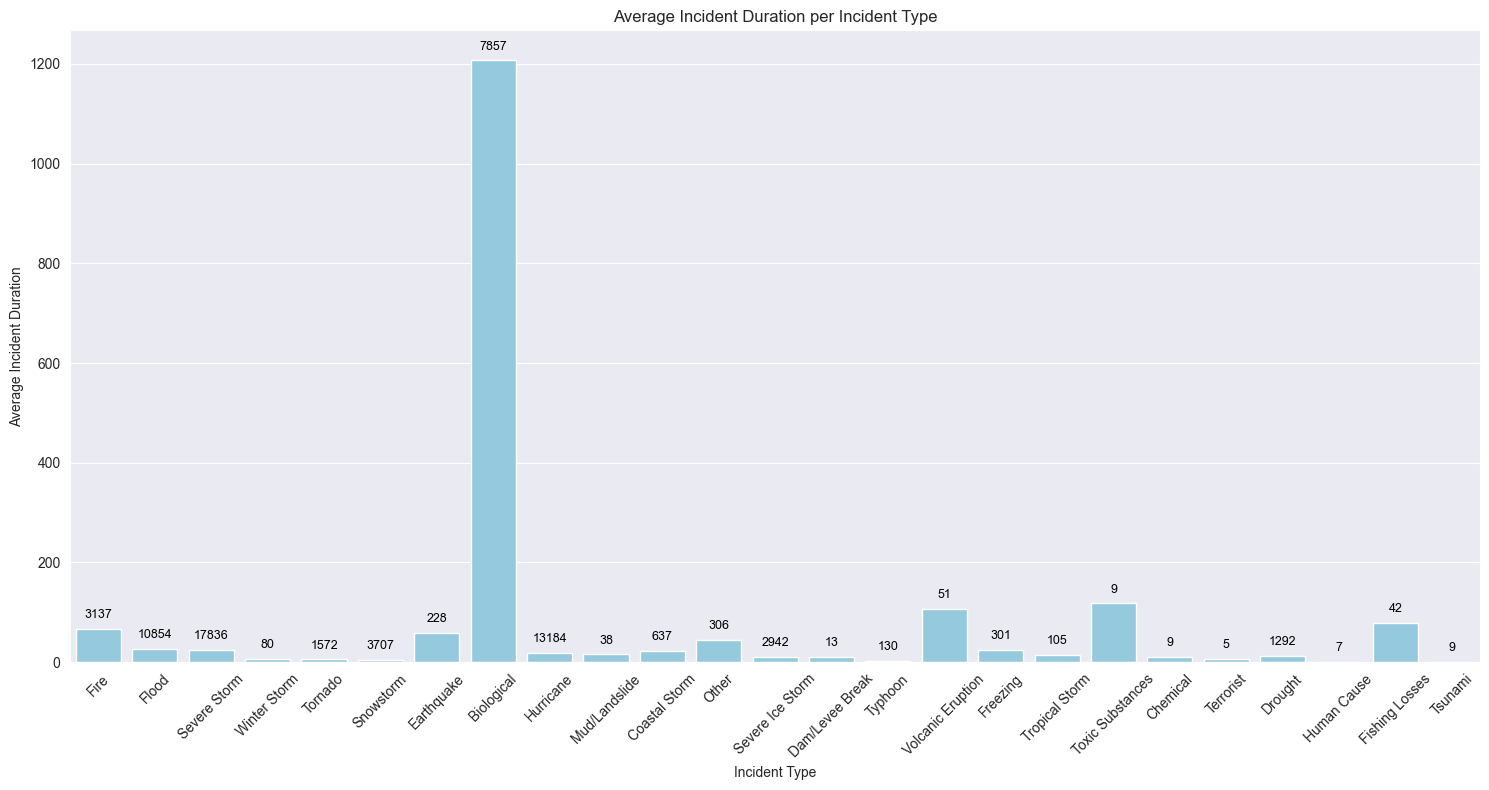

In [183]:
# Calculate the number of incidents for each incidentType
incident_counts = df.groupby('incidentType').size().reset_index(name='counts')

plt.figure(figsize=(15, 8))
barplot = sns.barplot(x='incidentType', y='incidentDuration', data=df, estimator=np.mean, ci=None, color='skyblue')
plt.title('Average Incident Duration per Incident Type')
plt.xlabel('Incident Type')
plt.ylabel('Average Incident Duration')
plt.xticks(rotation=45)

# Annotate bars with the number of incidents
for idx, p in enumerate(barplot.patches):
    count = incident_counts.loc[incident_counts['incidentType'] == barplot.get_xticklabels()[idx].get_text(), 'counts'].iloc[0]
    barplot.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=9, color='black', xytext=(0, 10),
                     textcoords='offset points')

plt.tight_layout()
plt.show()

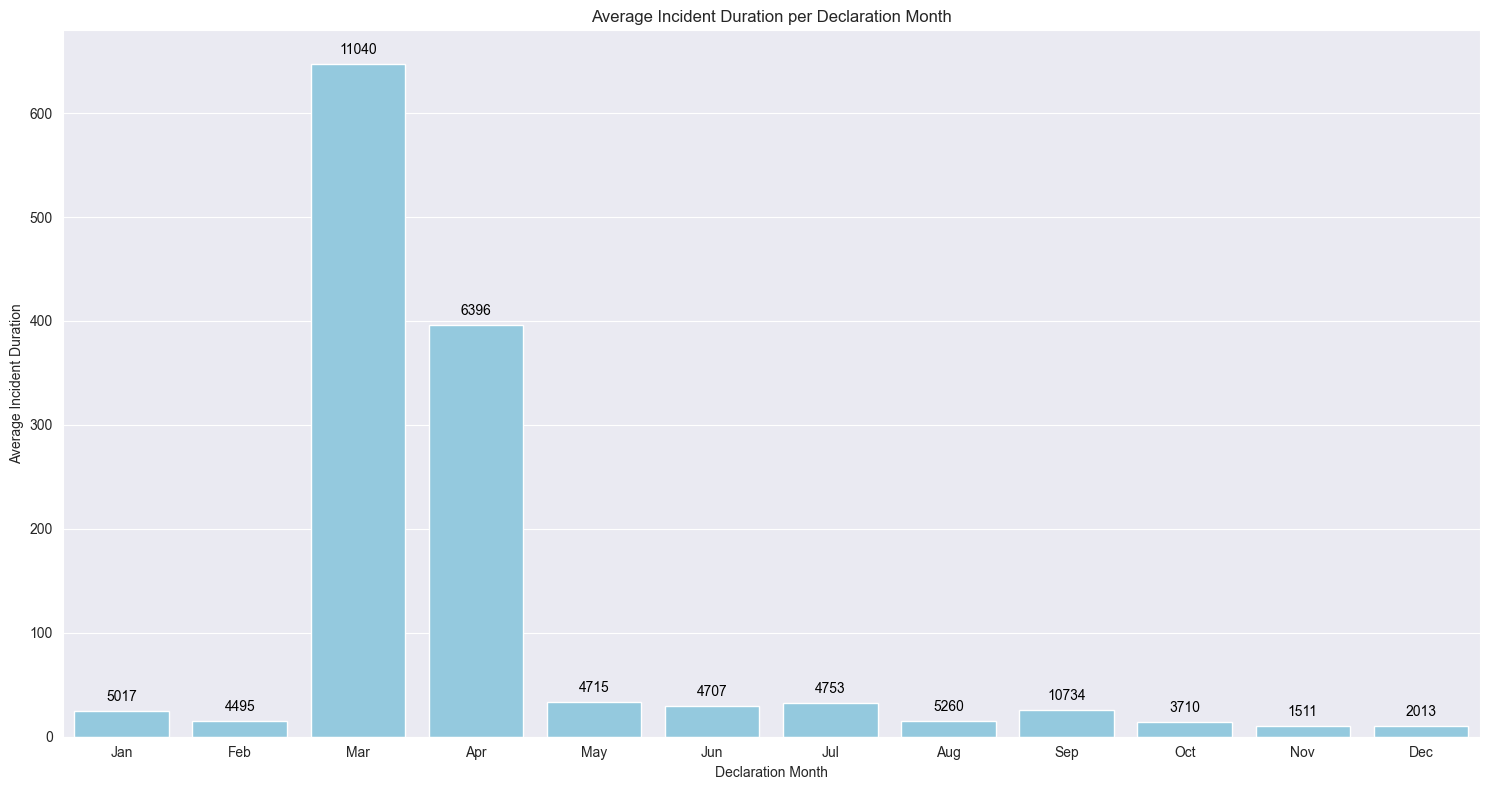

In [184]:
# Calculate the number of incidents for each declarationMonth
incident_counts = df.groupby('declarationMonth').size().reset_index(name='counts')

plt.figure(figsize=(15, 8))
barplot = sns.barplot(x='declarationMonth', y='incidentDuration', data=df, estimator=np.mean, ci=None, color='skyblue')
plt.title('Average Incident Duration per Declaration Month')
plt.xlabel('Declaration Month')
plt.ylabel('Average Incident Duration')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Annotate bars with the number of incidents
for idx, p in enumerate(barplot.patches):
    count = incident_counts.loc[incident_counts['declarationMonth'] == idx+1, 'counts'].iloc[0]
    barplot.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                     textcoords='offset points')

plt.tight_layout()
plt.show()

#### Drop incidences where the duration is less than 0

In [185]:
df = df[df['incidentDuration']>=0]

#### One hot encode categorical variables

In [186]:
df_ohe = pd.get_dummies(df, columns=['state', 'declarationType', 'incidentType', 'declarationMonth'])
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64349 entries, 0 to 64350
Columns: 106 entries, id to declarationMonth_12
dtypes: bool(104), int64(1), object(1)
memory usage: 7.9+ MB


In [187]:
df_ohe.head()

,id,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,tribalRequest,incidentDuration,state_AK,state_AL,state_AR,...,declarationMonth_3,declarationMonth_4,declarationMonth_5,declarationMonth_6,declarationMonth_7,declarationMonth_8,declarationMonth_9,declarationMonth_10,declarationMonth_11,declarationMonth_12
0,9b9a9d9c-8b03-4049-9b16-a3c0d581556c,False,False,True,True,False,2,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,57d936ce-a0d7-412a-9d78-18aee530c146,False,False,True,True,False,3,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,57cd8ff3-7ea3-49f6-923c-0c2573fa6582,False,False,True,True,False,19,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,689b511c-20a5-4037-b326-9c7046bbb0bc,False,False,True,True,False,19,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,9d62e711-dfe1-463d-a793-088912626de9,False,False,True,True,False,9,False,False,False,...,False,False,False,False,True,False,False,False,False,False


#### Define features and target variable

In [188]:
X = df_ohe.drop(columns=['incidentDuration'])
y = df_ohe['incidentDuration']
X.head()

,id,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,tribalRequest,state_AK,state_AL,state_AR,state_AS,...,declarationMonth_3,declarationMonth_4,declarationMonth_5,declarationMonth_6,declarationMonth_7,declarationMonth_8,declarationMonth_9,declarationMonth_10,declarationMonth_11,declarationMonth_12
0,9b9a9d9c-8b03-4049-9b16-a3c0d581556c,False,False,True,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,57d936ce-a0d7-412a-9d78-18aee530c146,False,False,True,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,57cd8ff3-7ea3-49f6-923c-0c2573fa6582,False,False,True,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,689b511c-20a5-4037-b326-9c7046bbb0bc,False,False,True,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,9d62e711-dfe1-463d-a793-088912626de9,False,False,True,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [189]:
y.head()

0     2
1     3
2    19
3    19
4     9
Name: incidentDuration, dtype: int64

#### Train-Test Split

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Save id

In [191]:
X_train_id = X_train['id']
X_test_id = X_test['id']

X_train = X_train.drop(columns=['id'])
X_test = X_test.drop(columns=['id'])

In [192]:
X_train_id.head()

43955    d04fccc5-2ae4-4013-aa99-9dc9c85cb9d1
21449    3d4f5171-a72d-4857-aa20-3c23013f5c60
33930    955161f8-f9c6-45fe-b95c-ccc3e2190613
53062    84b655a9-26dc-4390-b4cc-fb0432f16e9f
23313    8c411976-baea-4491-b034-b6d408110e73
Name: id, dtype: object

#### Hyperparameter tuning

In [193]:
# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 10, 12, 15],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'objective': ['reg:squarederror'],  # Regression objective
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

model = xgb.XGBRegressor()

# Random search of parameters
xgb_random = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                n_iter=100, scoring='neg_mean_squared_error',
                                cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
xgb_random.fit(X_train, y_train)

# Best parameters from the search
best_params = xgb_random.best_params_
print(best_params)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'subsample': 0.8, 'objective': 'reg:squarederror', 'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}


#### Model Training

In [194]:
# Initialize model
model = xgb.XGBRegressor(**best_params)

# Train the model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Model Evaluation

In [195]:
# Predictions
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 48.134747870730564


#### Calculate RMSE for each incident type

In [198]:
# Add the actual values, predicted values, and incidentType to a new DataFrame
df_results = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'id': X_test_id
})

df_results = pd.merge(df_results, df[['id', 'incidentType']], how='left', on='id')

# Calculate RMSE for each incidentType
df_results = df_results.groupby('incidentType').apply(lambda group: np.sqrt(mean_squared_error(group['actual'], group['predicted'])))
print(df_results)

incidentType
Biological              0.174015
Chemical                0.816454
Coastal Storm           8.849820
Dam/Levee Break         2.923250
Drought                10.926170
Earthquake             33.038848
Fire                   45.746409
Fishing Losses          1.848400
Flood                  18.041407
Freezing                1.941634
Human Cause             2.028376
Hurricane              10.056519
Mud/Landslide          80.841020
Other                  18.982375
Severe Ice Storm        2.093534
Severe Storm           13.004050
Snowstorm               2.898788
Terrorist               1.285698
Tornado                 3.609216
Toxic Substances      400.693951
Tropical Storm          0.967548
Tsunami                 1.403614
Typhoon                 4.592290
Volcanic Eruption    1474.794169
Winter Storm            0.598786
dtype: float64


In [199]:
# Merge to get incidentType for each observation
df_results = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'id': X_test_id
})
df_results = pd.merge(df_results, df[['id', 'incidentType']], how='left', on='id')

# Compute RMSE for each incidentType
rmse_per_type = df_results.groupby('incidentType').apply(lambda group: np.sqrt(mean_squared_error(group['actual'], group['predicted']))).reset_index()
rmse_per_type.columns = ['incidentType', 'RMSE']

# Compute average incidentDuration for each incidentType
avg_duration_per_type = df.groupby('incidentType')['incidentDuration'].mean().reset_index()
avg_duration_per_type.columns = ['incidentType', 'AvgIncidentDuration']

# Merge the two results
df_results_final = pd.merge(rmse_per_type, avg_duration_per_type, on='incidentType', how='inner')

print(df_results_final)

         incidentType         RMSE  AvgIncidentDuration
0          Biological     0.174015          1207.000000
1            Chemical     0.816454            11.000000
2       Coastal Storm     8.849820            21.824176
3     Dam/Levee Break     2.923250             9.923077
4             Drought    10.926170            12.602941
5          Earthquake    33.038848            59.039474
6                Fire    45.746409            66.462839
7      Fishing Losses     1.848400            78.428571
8               Flood    18.041407            25.688963
9            Freezing     1.941634            23.996678
10        Human Cause     2.028376             0.000000
11          Hurricane    10.056519            18.340792
12      Mud/Landslide    80.841020            15.421053
13              Other    18.982375            44.418301
14   Severe Ice Storm     2.093534            10.486064
15       Severe Storm    13.004050            23.833595
16          Snowstorm     2.898788             4

#### Plot Learning Curves

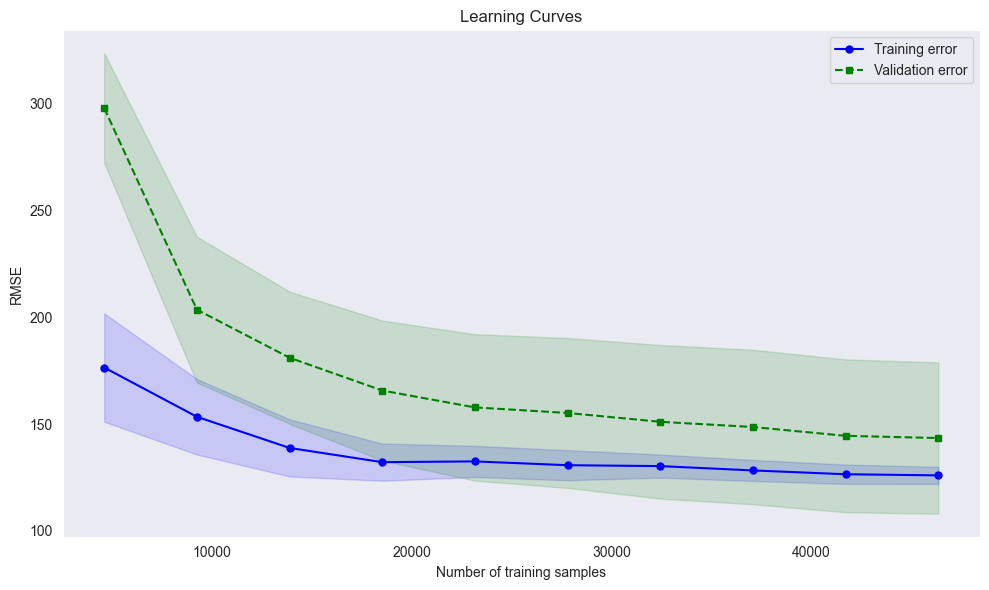

In [204]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model, X=X_train, y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = -np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training error')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation error')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.title('Learning Curves')
plt.xlabel('Number of training samples')
plt.ylabel('RMSE')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

#### Plot Validation Curve

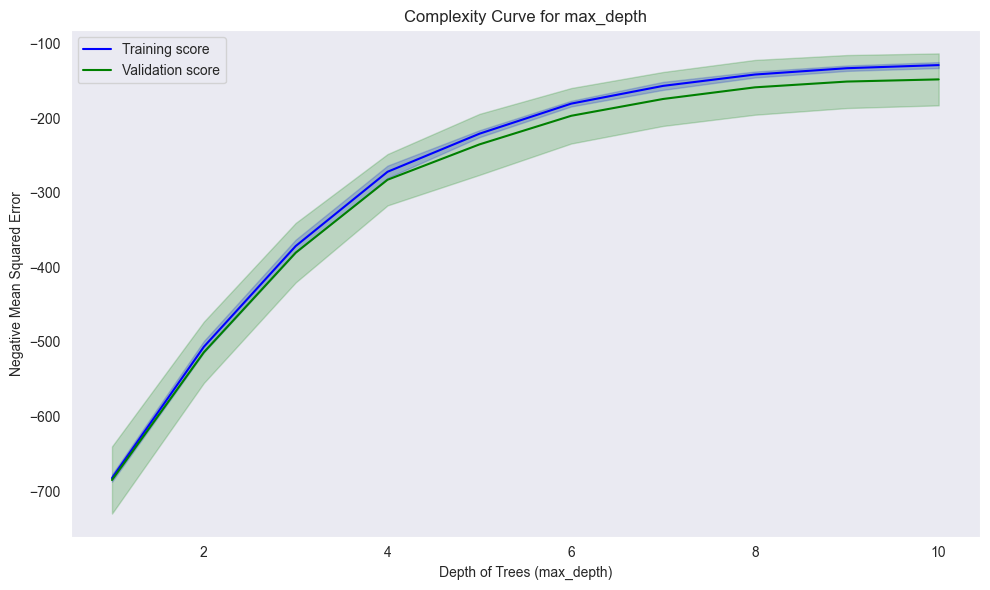

In [206]:
# Define range for max_depth
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Calculate accuracy on training and test set using the range of parameter values
train_scores, test_scores = validation_curve(
    estimator=xgb.XGBRegressor(objective='reg:squarederror'),
    X=X_train,
    y=y_train,
    param_name="max_depth",
    param_range=param_range,
    cv=10,
    scoring="neg_mean_squared_error",
    n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.figure(figsize=(10,6))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.plot(param_range, test_mean, label="Validation score", color="green")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="green", alpha=0.2)

# Create plot
plt.title("Complexity Curve for max_depth")
plt.xlabel("Depth of Trees (max_depth)")
plt.ylabel("Negative Mean Squared Error")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.show()

#### Plot Feature Importance

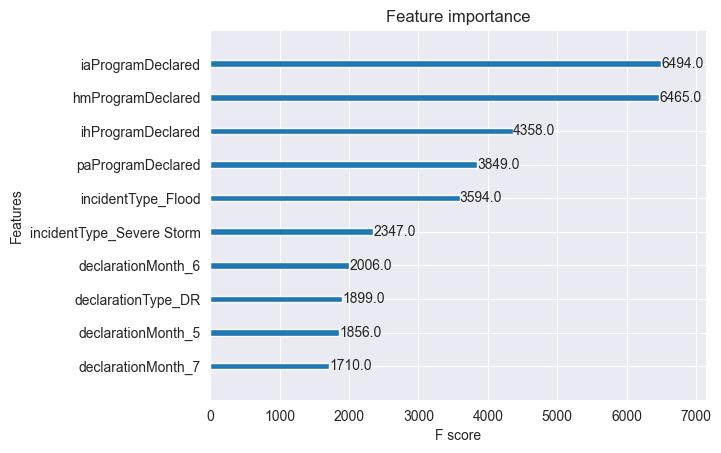

In [207]:
xgb.plot_importance(model, importance_type='weight', max_num_features=10)
plt.show()